In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from keyword_fetcher import KeywordFetcher
from data_parser import DataParser

In [2]:
TERM_PATH = "../data/frequent_terms.csv"
BIGRAM_PATH = "../data/frequent_bigrams.csv"
TRIGRAM_PATH = "../data/frequent_trigrams.csv"
US_DAILY_PATH = "../data/covid19-in-usa/us_covid19_daily.csv"
STATES_DAILY_PATH = "../data/covid19-in-usa/us_states_covid19_daily.csv"
REGION_LIST_PATH = "../data/abbr-list.csv"
KW_30_US_PATH = "../data/trends/keywords_30_US.csv"

### Generate Keyword list

In [6]:
kf = KeywordFetcher("../data/frequent_terms.csv", "../data/frequent_bigrams.csv", "../data/frequent_trigrams.csv")
kw = kf.generate_keyword_list(num_features=10)

In [7]:
kw

,keyword,count
0,coronavirus,28120854
1,covid19,8630451
2,covid,8171888
3,19,7903151
4,nan,3888201
5,people,2645140
6,via,2321653
7,china,2225140
8,amp,2143277
9,trump,2038513


## Fetch Google trends result

In [9]:
# result_us = kf.fetch_trends(kw, "2020-01-21", "2020-05-01", 'US', "../data/trends/keywords_30_US.csv")
result_us = pd.read_csv('../data/trends/keywords_30_US.csv')

In [10]:
result_us.head(1)

,date,coronavirus,covid19,covid,19,nan,people,via,china,amp,...,due coronavirus,novel coronavirus,new york,covid 19 pandemic,coronavirus covid 19,covid 19 cases,covid 19 crisis,coronavirus death toll,due covid 19,bbc news coronavirus
0,2020-01-21,2,0,0,9,84,54,95,39,88,...,0,20,63,0,0,0,0,0,0,0


In [12]:
region_list = list(pd.read_csv(REGION_LIST_PATH)["####"])

In [ ]:
for region in region_list:
    kf.fetch_trends(kw, "2020-01-21", "2020-05-01", 'US-'+region, "../data/trends/keywords_30_US-{}.csv".format(region))

## Parse keyword and patient data

In [4]:
parser = DataParser(keywords_path=KW_30_US_PATH, cases_path=US_DAILY_PATH)
d_avg = parser.process_labels()
train_matrix = parser.process_data_sample(label_array=d_avg)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_matrix[train_matrix.shape[0]-d_avg.shape[0]:], 
                                                    d_avg, test_size=0.15, shuffle=False) 

In [6]:
train_matrix

array([[-0.49370222, -0.74254115, -0.74254115, ..., -0.52785659,
        -0.74254115, -0.63519887],
       [-0.45875162, -0.76368968, -0.76368968, ..., -0.44907104,
        -0.76368968, -0.61848108],
       [-0.42959961, -0.7816748 , -0.7816748 , ..., -0.35725539,
        -0.7816748 , -0.61287163],
       ...,
       [-0.45014989, -0.04677836,  1.08398446, ..., -0.21209456,
        -0.33112223, -0.99899968],
       [-0.46488769, -0.05043593,  1.07450456, ..., -0.20174371,
        -0.3070013 , -0.94512544],
       [-0.53497822, -0.07155606,  1.07068168, ..., -0.20209751,
        -0.26084117, -0.92660259]])

## Train models

In [7]:
## Elastic Net
#########################################################
EN_reg = ElasticNet(alpha=1,l1_ratio=1.0,max_iter=15000)
EN_reg.fit(X_train,y_train)

pred_ELN = EN_reg.predict(X_test)
diff = y_test-pred_ELN

In [8]:
## MLP
#########################################################
MLP_regressor = MLPRegressor(hidden_layer_sizes=(20,20,5),alpha=1,
                             learning_rate_init=0.01,max_iter=20000,n_iter_no_change=100)
MLP_regressor.fit(X_train,y_train)

pred_MLP = MLP_regressor.predict(X_test)
diff = y_test-pred_MLP

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0.5, 1.0, 'new increase pred in 4/19-5/2')

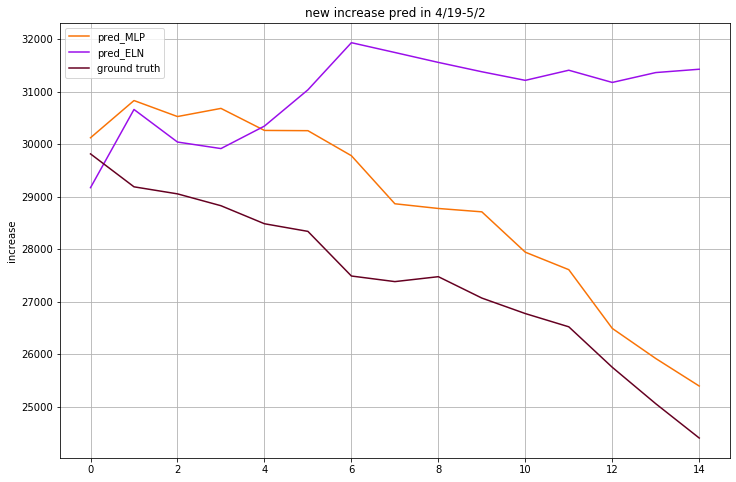

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
ax1.plot(pred_MLP, 'xkcd:orange')
ax1.plot(pred_ELN, 'xkcd:violet')
ax1.plot(y_test, 'xkcd:maroon')
ax1.set_ylabel('increase')
ax1.legend(['pred_MLP','pred_ELN','ground truth'])
ax1.grid(True)
ax1.set_title('new increase pred in 4/19-5/2')